In [3]:
# regressao linear

# tarefa preditiva que tenta achar reta universal dado um conjunto de amostras

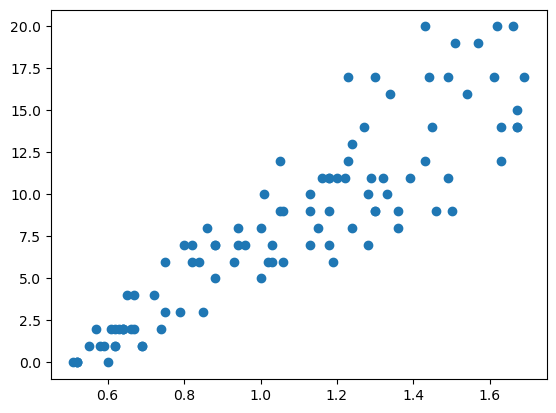

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# dados sao matriz de duas colunas
data = np.loadtxt('../data/age_data_1.txt') # funcao que le arquivo txt
x, y = data.T # data.T pega matriz transposta com 2 linhas e n colunas (original eh 2 colunas e n linhas) -> desempacota e poem em x e y

# scatter -> argumentos sao: array de valores em x, array de valores em y -> grafico de pontos
plt.scatter(x, y)

# grafico permite perceber que variaveis provavelmente tem alguma relacao linear entre elas

In [5]:
# modelo linear

# ym = ax + b, ym eh valor modelado/estimado


# nos dados usados y eh a idade e x altura

In [6]:
# classe modelo que vai representar modelo de aprendizado
class Model:

    def __init__(self, a, b):
        self.a = a
        self.b = b
    
    # sobreescreve operacao model() permitindo chamar instancia como se fosse funcao
    # retorna array com y previstos
    def __call__(self, x):
        return self.a * x + self.b # possivel pela operacao de broadcastiing
    
    # retorna copia do modelo para evitar perder modelo original em futuras operacoes inplace em cima dos parametros a e b
    def copy(self):
        return Model(self.a, self.b)

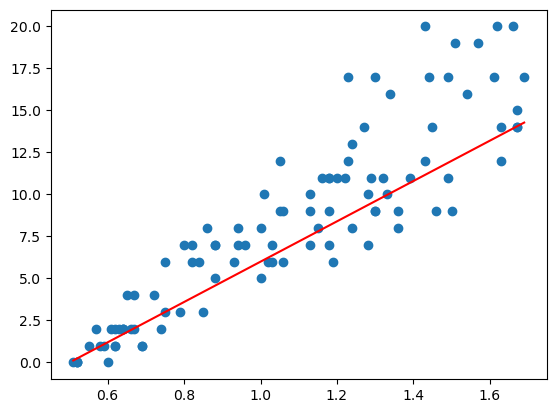

In [7]:
model = Model(a=12, b=-6)
xm = np.linspace(x.min(), x.max()) # linspace cria vetor com valores distribuidos os dois valores passados
ym = model(xm)


# quando colocados em sequencia gera plots na mesma figura
# ou seja, se quer separar plots, usa plt.subplots, caso nao usa direto plt
plt.scatter(x, y) 
# plota pontos passados em x e y e ligam eles
plt.plot(xm, ym, c='r') # c permite escolher cor do objeto plotado

In [8]:
# metrica de qualidade de regressao linear mais usado é erro quadratico medio
# erro_q_medio = [soma(y-ym) ** 2]/n

# mse = mean of squared error
def mse(model, x, y):
    
    ym = model(x)

    error = np.mean((y-ym)**2)

    return error

mse(model, x, y)

8.027488

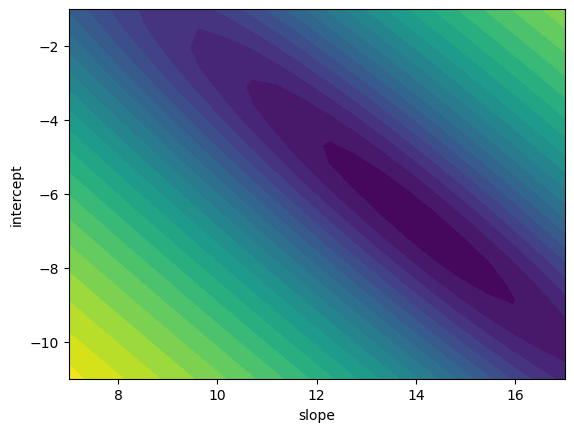

In [9]:
# para melhorar modelo

# maneira de visualizar o que acontece com erro com mudanças de parametros
def get_local_error(model, x, y, par_range=1.):
    size = 20 # num de pontos usados na visualizacao
    a, b = model.a, model.b
    a_vals = np.linspace(a-par_range, a+par_range, size) # gera array com 20 valores de a no intervalo a - 5, a + 5
    b_vals = np.linspace(b-par_range, b+par_range, size)

    error_grid = np.zeros((size, size))

    for i, b_val in enumerate(b_vals):
        for j, a_val in enumerate(a_vals):
            close_model = Model(a_val, b_val)
            error = mse(close_model, x, y)
            error_grid[i, j] = error
    
    return error_grid, a_vals, b_vals

# funcao que plota o que acontece quando parametros a e b variam
def plot_local_error(model, x, y, par_range=1.):
    error_grid, a_vals, b_vals = get_local_error(model, x, y, par_range)
    plt.figure()
    plt.contourf(a_vals, b_vals, np.log(error_grid), levels=30) # gera grafico de cores em que mais azul escuro = menor 
                                                                # (depende do mapa usado)
                                                                # log espreme valores e melhora visualizacao
    plt.xlabel('slope')
    plt.ylabel('intercept')

plot_local_error(model, x, y, par_range=5)

# quanto mais amarelo e verde maior o valor e quanto mais azul escuro menor o erro
# cor, portanto, indica erro

# grafico mostra que melhores valores para coeficiente angular (slope) e linear (intercept) sao proximos de 14 e -6

In [10]:
# medir derivadas parciais permite medir o quanto uma variavel atua na variacao de uma funcao multi-variavel
# gradiente = (deriavada parcial f/x1, derivada parcial f/x2) e permite entender variacao
# estando num ponto (x0, y0), o gradiente eh um vetor que indica em qual sentido e direcao andar para que o valor de f aumente mais rapidamente
# logo, o vetor -gradiente indica qual direcao e sentido andar para que f diminua mais rapidamente

# fazendo as derivadas parciais de mse em relacao a a e b, pois a e b sao as variaveis da funcao mse que se deseja diminuir

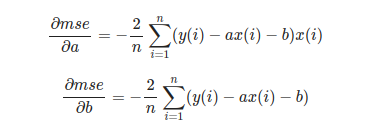

In [11]:
# funcao que retorna gradiente da funcao mse do modelo
def mse_grad(model, x, y):

    ym = model(x)
    n = len(x)
    ga = -2/n*np.sum((y - ym) * x)
    gb = -2*np.sum((y - ym))/n

    return ga, gb

grad = mse_grad(model, x, y)


-2.8271999999999995 -5.886912


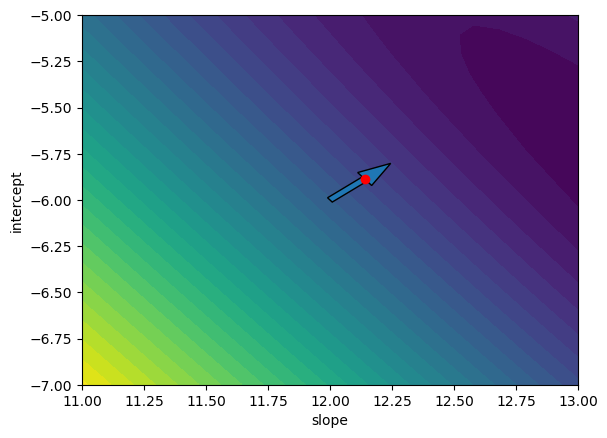

In [12]:
plot_local_error(model, x, y, par_range=1)
# plota uma seta na direcao do gradiente e lr define o comprimento da seta em relacao ao comprimento original do gradiente
lr = 0.04
print(grad[1], model.b - lr*grad[1])
# desenha seta com base em model.a, model.b e com comprimento e altura definidos por dx, dy
# nesse caso a seta aponta para direcao que diminui mais rapidamente a funcao mse
plt.arrow(model.a, model.b, -lr*grad[0], -lr*grad[1], width=0.03)
plt.scatter([model.a - lr*grad[0]], [model.b - lr*grad[1]], c='r')

novo ponto pós-salto:
12.14019808 -5.886912


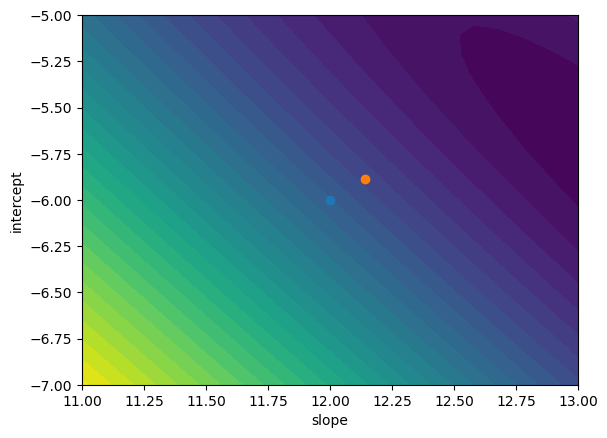

In [13]:
# funcao usada para variar valores do coeficiente do modelo na direcao da onde decresce
# taxa lr eh usada para ir aos poucos na direcao do gradiente e evitar divergir, pois gradiente aponta para uma direcao de estimativa ja que nao conhece funcao global
# funcao mse usada eh local
def step(model, x, y, lr):
    ''' da um passo de gradiente descendente '''

    grad = mse_grad(model, x, y)
    model.a = model.a - lr*grad[0] # uso do sinal negativo eh pra ir na direcao onde a funcao decresce mais rapidamente
    model.b = model.b - lr*grad[1]

# copia do modelo original para nao perder e poder comparar futuramente
model_original = model.copy()

step(model, x, y, lr=0.04)
plot_local_error(model_original, x, y)
plt.scatter(model_original.a, model_original.b)
plt.scatter(model.a, model.b)
print('novo ponto pós-salto:')
print(model.a, model.b)

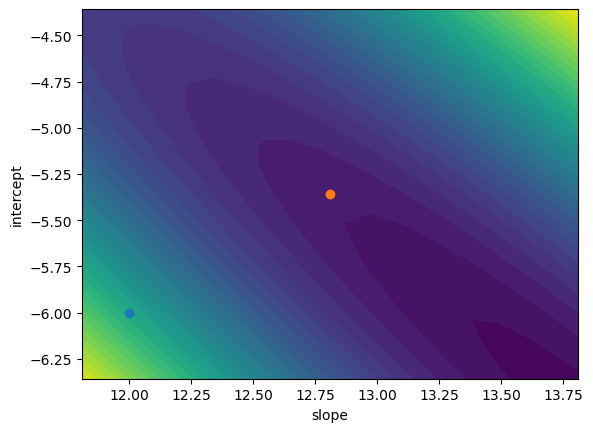

In [14]:
# fazendo passo maior
model_or = model_original.copy()

step(model, x, y, lr=0.23)
plot_local_error(model, x, y, par_range=1)
plt.scatter(model_or.a, model_or.b)
plt.scatter(model.a, model.b)

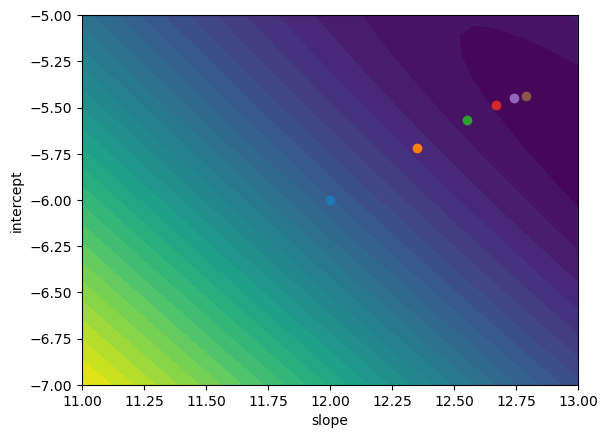

In [15]:
# aplicando varios passos usando lr = 0.1 (bom valor)
modelo = Model(a=12, b=-6)

plot_local_error(modelo, x, y, par_range=1)

modelo_original = modelo.copy()
# plot do ponto original a, b de comeco
plt.scatter(modelo_original.a, modelo_original.b)
# plot do segundo ponto a, b depois do ajuste usando o gradiente e taxa lr = 0.1
step(modelo, x, y, lr=0.1)
plt.scatter(modelo.a, modelo.b)
step(modelo, x, y, lr=0.1)
# plot do terceiro ponto a, b depois do ajuste usando o gradiente e taxa lr = 0.1
plt.scatter(modelo.a, modelo.b)

# repetir processo vai aproximando do lugar ideal
step(modelo, x, y, lr=0.1)
plt.scatter(modelo.a, modelo.b)
step(modelo, x, y, lr=0.1)
plt.scatter(modelo.a, modelo.b)
step(modelo, x, y, lr=0.1)
plt.scatter(modelo.a, modelo.b)






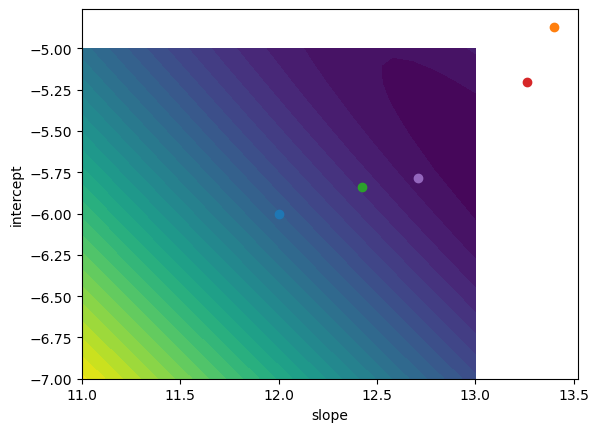

In [16]:
# aplicando varios passos usando lr = 0.4 causa divergencia
lr = 0.4
modelo = Model(a=12, b=-6)

plot_local_error(modelo, x, y, par_range=1)

modelo_original = modelo.copy()
# plot do ponto original a, b de comeco
plt.scatter(modelo_original.a, modelo_original.b)
# plot do segundo ponto a, b depois do ajuste usando o gradiente e taxa lr = 0.1
step(modelo, x, y, lr)
plt.scatter(modelo.a, modelo.b)
step(modelo, x, y, lr)
# plot do terceiro ponto a, b depois do ajuste usando o gradiente e taxa lr = 0.1
plt.scatter(modelo.a, modelo.b)
step(modelo, x, y, lr)
plt.scatter(modelo.a, modelo.b)
step(modelo, x, y, lr)
plt.scatter(modelo.a, modelo.b)

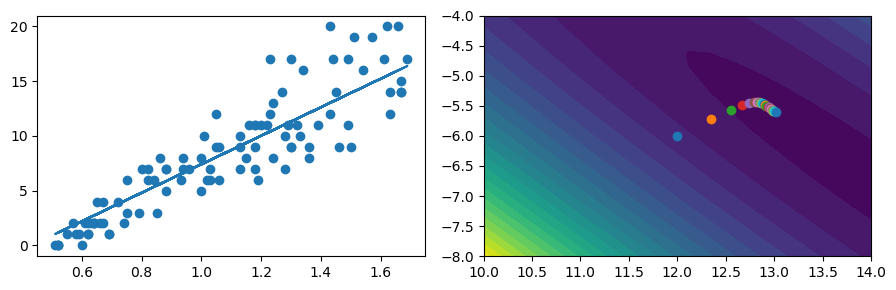

In [17]:
from IPython import display

# loop de treinamento: ideia eh iterar um numero de vezes num_epochs e ir com base no gradiente consertando os coeficientes a e b
# funcao mostra evolucao com tempo
def train(modelo, x, y, lr, num_epochs):

    fig = plot_figure(modelo, x, y)

    for i in range(num_epochs):
        print('mse: ' + str(mse(modelo, x, y)))
        step(modelo, x, y, lr)
        plot_figure(modelo, x, y, fig)


def plot_figure(modelo, x, y, fig=None):
    ym = modelo(x)

    if fig is None:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))
        ax1.scatter(x, y)
        ax1.plot(x, ym)

        error_grid, a_vals, b_vals = get_local_error(modelo, x, y, par_range=2)
        ax2.contourf(a_vals, b_vals, error_grid, levels=30)
        ax2.scatter(modelo.a, modelo.b)
    else:
        ax1, ax2 = fig.axes
        ax1.lines[0].set_data(x, ym)
        ax2.scatter(modelo.a, modelo.b)

    plt.tight_layout()
    plt.close()

    display.clear_output(wait=True)
    display.display(fig)

    return fig


modelo = Model(12, -6)
train(modelo, x, y, 0.1, 20)

matemática:

mse da regressão linear é uma função convexa, o que significa que traçar uma reta usando dois pontos quaisquer da função sempre deixará a reta acima da função

Logo, não existe mínimos locais e apenas um global

Portanto, basta esperar o suficiente e não definir o learning rate muito alto para atingir o mínimo global

Gráfico do custo tem formato de tijela que é distorcido a depender da escala usada (na imagem abaixo, na esquerda as escalas são parecidas)

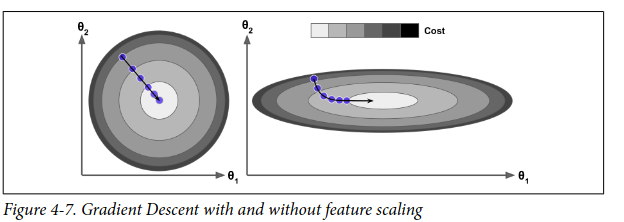

Portanto, treinar um modelo significa procurar uma combinação de parâmetros do modelo que minimiza a função de custo 
Busca no espaço de parâmetros do modelo, quanto mais dimensões mais difícil a busca

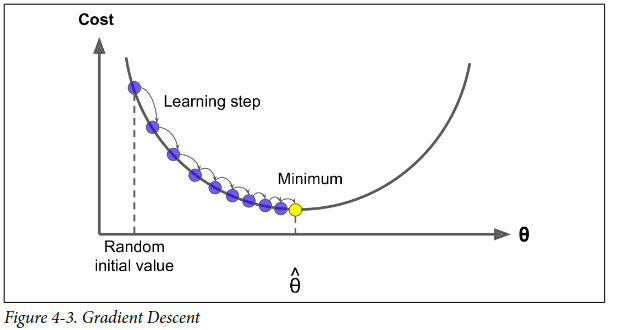

In [18]:
# regressao linear de duas variaveis

# ym = w1x1 + w2x2 + b

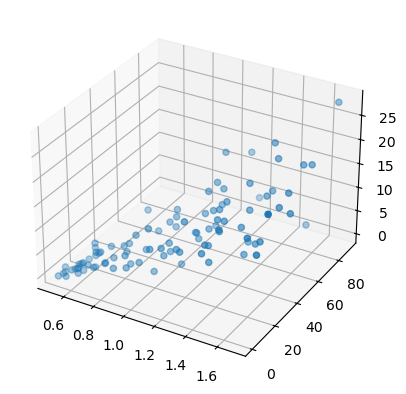

In [5]:
import matplotlib.pyplot as plt
import numpy as np
data = np.loadtxt('../data/age_data_2.txt')
x1, x2, y = data.T

# maneira de fazer visualizacao 3D -> adicionar subplot com projecao 3D
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x1, x2, y)


[1.3  0.64 1.49 0.96 1.67 0.66 1.36 0.75 1.02 0.62 1.06 1.18 1.29 1.15
 1.13 1.27 1.18 1.18 1.63 0.72 1.66 0.65 0.69 1.23 1.62 0.55 0.61 1.69
 1.61 1.22 1.46 1.67 1.49 0.88 1.18 1.   0.8  0.94 0.67 1.36 1.23 0.67
 0.93 0.52 1.43 0.88 0.74 0.57 1.45 0.52 0.79 1.63 1.05 1.44 1.54 0.6
 0.52 0.64 1.28 0.85 0.62 0.86 1.28 0.82 1.51 1.06 0.84 1.24 1.32 1.24
 0.59 1.01 1.13 0.94 1.   0.64 0.82 1.03 0.58 1.3  0.63 1.33 0.62 0.51
 1.05 1.19 1.2  1.43 1.03 1.13 1.39 1.34 0.69 0.75 1.16 1.57 1.3  0.88
 1.67 1.5 ] (100,) [[0.51       0.53408163 0.55816327 ... 1.64183673 1.66591837 1.69      ]
 [0.51       0.53408163 0.55816327 ... 1.64183673 1.66591837 1.69      ]
 [0.51       0.53408163 0.55816327 ... 1.64183673 1.66591837 1.69      ]
 ...
 [0.51       0.53408163 0.55816327 ... 1.64183673 1.66591837 1.69      ]
 [0.51       0.53408163 0.55816327 ... 1.64183673 1.66591837 1.69      ]
 [0.51       0.53408163 0.55816327 ... 1.64183673 1.66591837 1.69      ]] (50, 50)
(50, 50)


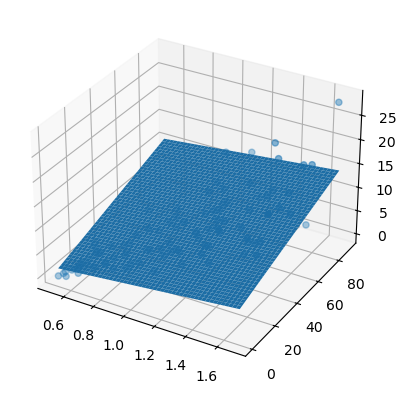

In [10]:
import numpy as np

class Model:

    def __init__(self, w1, w2, b):
        self.w1 = w1
        self.w2 = w2
        self.b = b

    def __call__(self, x1, x2):
        return self.w1*x1 + self.w2*x2 + self.b
    
model = Model(3, 0.1, 0)
# obtem grids, matrizes de tamanho (50, 50)
# para x1m cada linha eh a copia do vetor gerado por linspace
# para x2m cada coluna eh a copia do vetor gerado por linspace
# usado para gerar a base dimensional 2D que permite fazer combinacao linear ym = w1x1 + w2x2 + b ao passar pro modelo
x1m, x2m = np.meshgrid(
    np.linspace(x1.min(), x1.max()), # tem por valor default 50 pontos
    np.linspace(x2.min(), x2.max())
)

# modelo faz todas combinacoes possiveis de (x1, x2) em ym = w1 x1 + w2 x2 + b 
ym = model(x1m, x2m)

print(x1, x1.shape, x1m, x1m.shape)
print(ym.shape)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x1, x2, y)
# plotas bases dimensionais x1m, x2m e ym nas alturas
ax.plot_surface(x1m, x2m, ym)

In [1]:
def mse(model, x1, x2, y):

    ym = model(x1, x2)
    error = np.mean((y-ym)**2)

    return error

def mse_grad(model, x1, x2, y):

    n = len(x1)
    ym = model(x1, x2)
    gw1 = -2*np.sum((y-ym)*x1)/n
    gw2 = -2*np.sum((y-ym)*x2)/n
    gb = -2*np.sum(y-ym)/n

    return gw1, gw2, gb

def step(model, x1, x2, y, lr):

    grad = mse_grad(model, x1, x2, y)
    model.w1 = model.w1 - lr*grad[0]
    model.w2 = model.w2 - lr*grad[1]
    model.b = model.b - lr*grad[2]

    return model
